In [162]:
from sys import argv
import yfinance as yf
import mplfinance as mpf
import sqlite3
import warnings
warnings.simplefilter("ignore")
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

## NASDAQ

In [213]:
ndx = yf.download('^IXIC', start = "2015-01-01", end = "2022-11-24")

[*********************100%***********************]  1 of 1 completed


In [214]:
ndx = ndx.reset_index()

In [215]:
ndx.shape

(1989, 7)

In [229]:
training_set = ndx.iloc[:1400, 1:2].values
test_set = ndx.iloc[1400:, 1:2].values

In [230]:
# Feature Scaling --> scale the stock prices between (0, 1) to avoid intensive computation. 
# Normalization
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(4940, 60, 1)

In [231]:
X_train.shape

(1340, 60, 1)

In [232]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularization
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
42/42 [==============================] - 9s 61ms/step - loss: 0.0174
Epoch 2/20
42/42 [==============================] - 3s 62ms/step - loss: 0.0045
Epoch 3/20
42/42 [==============================] - 3s 62ms/step - loss: 0.0051
Epoch 4/20
42/42 [==============================] - 3s 61ms/step - loss: 0.0039
Epoch 5/20
42/42 [==============================] - 3s 61ms/step - loss: 0.0035
Epoch 6/20
42/42 [==============================] - 3s 62ms/step - loss: 0.0032
Epoch 7/20
42/42 [==============================] - 3s 71ms/step - loss: 0.0037
Epoch 8/20
42/42 [==============================] - 3s 63ms/step - loss: 0.0033
Epoch 9/20
42/42 [==============================] - 3s 61ms/step - loss: 0.0028
Epoch 10/20
42/42 [==============================] - 3s 74ms/step - loss: 0.0029
Epoch 11/20
42/42 [==============================] - 3s 74ms/step - loss: 0.0029
Epoch 12/20
42/42 [==============================] - 3s 72ms/step - loss: 0.0027
Epoch 13/20
42/42 [==================

In [233]:
real_ndx_price = test_set

In [234]:
dataset_train = ndx.iloc[:1400, 1:2]
dataset_test = ndx.iloc[1400:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

In [235]:
len(dataset_test)

589

In [236]:
#Create the input for prediction, index starting from the date 60 days before the first date in the test dataset.
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#Reshape to have only 1 column
inputs = inputs.reshape(-1,1)
#Using the scale set by the training set, scale the test inputs.
inputs = sc.transform(inputs)

In [237]:
#Create test data structure
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (762, 60, 1)

(589, 60, 1)


In [238]:
predicted_ndx_price = model.predict(X_test)

19/19 [==============================] - 2s 20ms/step


In [239]:
predicted_ndx_price = sc.inverse_transform(predicted_ndx_price)


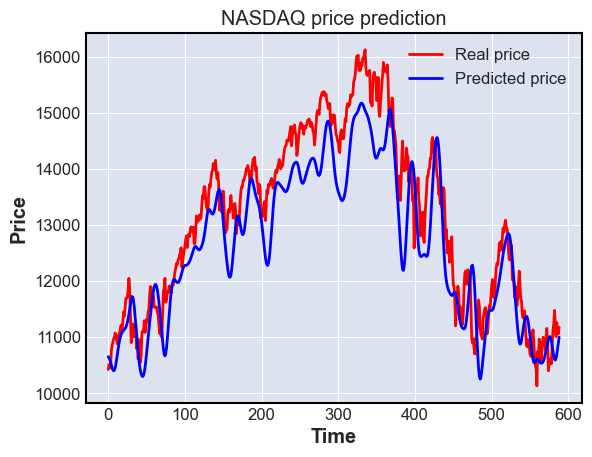

In [241]:
plt.plot(real_ndx_price, color = "r", label = 'Real price')
plt.plot(predicted_ndx_price, color = "b", label = 'Predicted price')
plt.title('NASDAQ price prediction')
plt.xlabel('Time')
#plt.yscale('log')
plt.ylabel('Price')
plt.legend()
plt.show()

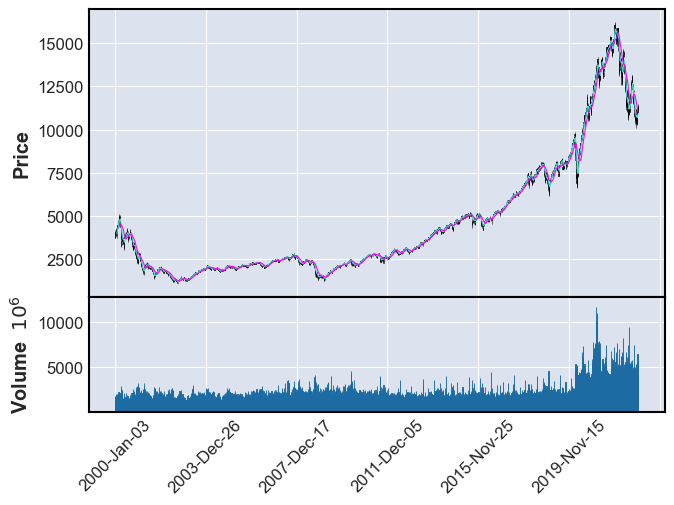

In [68]:
mpf.plot(ndx, type = 'candle', mav=(21, 55), volume = True)

[*********************100%***********************]  1 of 1 completed


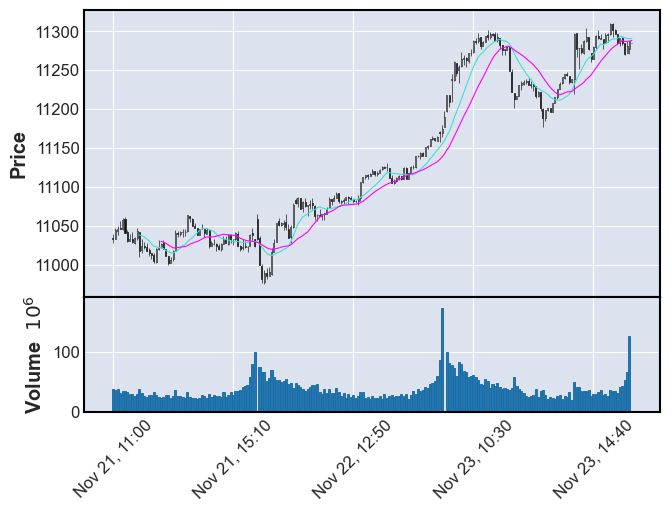

In [69]:
intraday_ndx = yf.download(tickers= '^IXIC', period = "5d", interval = "5m")
iday = intraday_ndx.loc["2022-11-21 11:00":"2022-11-24 12:00", :]
mpf.plot(iday, type="candle", mav=(12, 21), volume = True)

## SP 500

In [5]:
spx = yf.download('^GSPC', start = "2000-01-01", end = "2022-11-24")

[*********************100%***********************]  1 of 1 completed


In [6]:
spx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


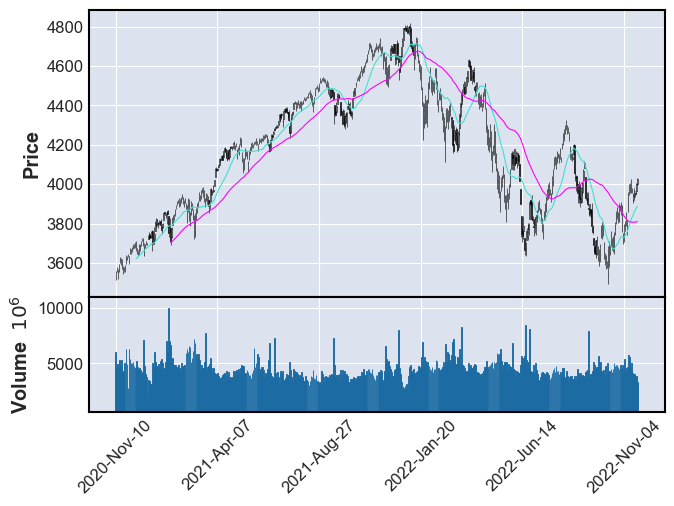

In [115]:
mpf.plot(spx, type = 'candle', mav=(21,55), volume = True, style = 'default')

[*********************100%***********************]  1 of 1 completed


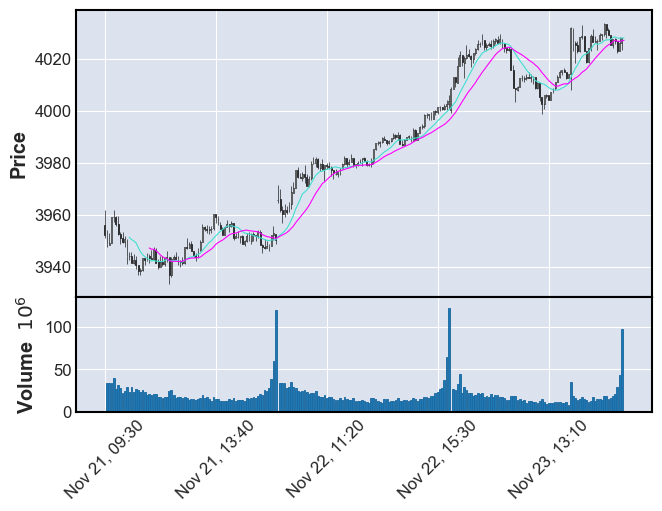

In [111]:
intraday_spx = yf.download(tickers= '^GSPC', period = "5d", interval = "5m")
iday_spx = intraday_spx.loc["2022-11-20 11:00":"2022-11-24 12:00", :]
mpf.plot(iday_spx, type="candle", mav=(12, 21), volume = True)

## GOLD

In [11]:
gold = yf.download('GC=F', start = "2000-01-01", end = "2022-11-24")

[*********************100%***********************]  1 of 1 completed


In [12]:
gold.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0


[*********************100%***********************]  1 of 1 completed


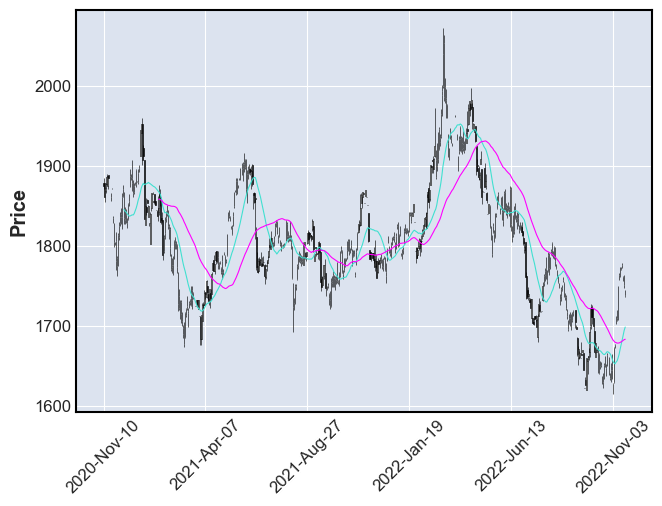

In [125]:
mpf.plot(gold, type = 'candle', mav=(21,55), style = 'default')

[*********************100%***********************]  1 of 1 completed


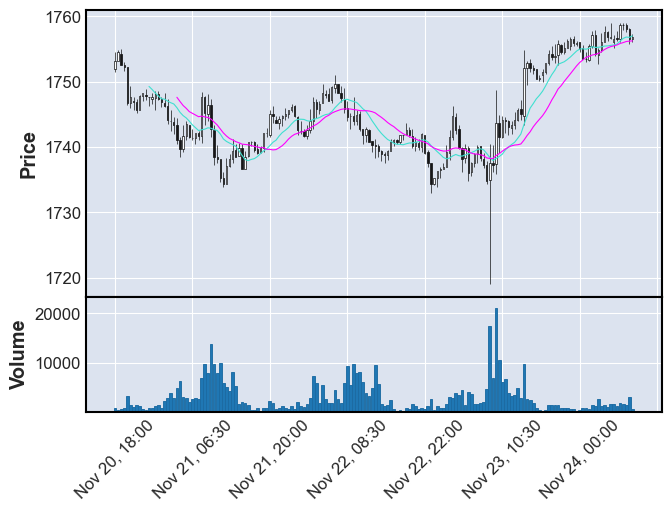

In [128]:
intraday_gold = yf.download(tickers= 'GC=F', period = "5d", interval = "30m")
iday_gold = intraday_gold.loc["2022-11-20 11:00":"2022-11-24 12:00", :]
mpf.plot(iday_gold, type="candle", mav=(12, 21), volume = True)

In [2]:
#con = sqlite3.connect("market_data.sqlite")

In [3]:
#This uses yfinance, moves the date to a column, renames the columns, and adds the symbol.
#def get_stock_data(symbol, start, end):
    #data = yf.download(symbol, start= start, end= end)
    #data.reset_index(inplace = True)
    #data.rename(columns = {"Date":"date", "Open": "open", "Low":"low", "Close":"close", "Adj Close": "adj_close", "Volume":"volume"}, inplace = True)
    #data["symbol"]=symbol
    #return data

In [4]:
#Create a function that uses `get_stock_data` to get a range of stock data and insert it into the market database.
#The function uses pandas to connect to the database and insert the data in the DataFrame into the database.
#Finally, get the last trading day's data.
#def save_data_range (symbol, start, end):
    #data = get_stock_data(symbol, start, end)
    #data.to_sql(
        #"stock_data",
        # con,
        # if_exists="append",
         #index=False)

In [5]:
#Create a function that inserts the last trading day into the database.
#This is useful for automating the script to get the current day's data.
#def save_last_trading_session (symbol):
    #today = pd.Timestamp.today()
    #data = get_stock_data(symbol, today, today)
    #data.to_sql(
        #"stock_data",
        #con,
        #if_exists="append",
        #index=False)

In [6]:
#save_data_range("NDX", "1990-01-01", "2022-11-16")

[*********************100%***********************]  1 of 1 completed


In [7]:
#ndx = pd.read_sql_query("Select * from stock_data where symbol ='NDX'", con)

In [8]:
#ndx.head()

,date,open,High,low,close,adj_close,volume,symbol
0,2000-01-03 00:00:00,3755.739990,3836.860107,3643.25000,3790.550049,3790.550049,1510070000,NDX
1,2000-01-04 00:00:00,3766.570068,3766.570068,3542.72998,3546.199951,3546.199951,1511840000,NDX
2,2000-01-05 00:00:00,3543.129883,3576.169922,3371.75000,3507.310059,3507.310059,1735670000,NDX
3,2000-01-06 00:00:00,3488.310059,3513.550049,3334.02002,3340.810059,3340.810059,1598320000,NDX
4,2000-01-07 00:00:00,3337.260010,3529.750000,3314.75000,3529.600098,3529.600098,1634930000,NDX


In [13]:
#save_data_range("SPY", "1995-01-01", "2022-11-16")

[*********************100%***********************]  1 of 1 completed


In [14]:
#spy = pd.read_sql_query("Select * from stock_data where symbol ='SPY'", con)
#spy[:10]

,date,open,High,low,close,adj_close,volume,symbol
0,2000-01-03 00:00:00,148.25000,148.25000,143.875000,145.43750,95.746429,8164300,SPY
1,2000-01-04 00:00:00,143.53125,144.06250,139.640625,139.75000,92.002220,8089800,SPY
2,2000-01-05 00:00:00,139.93750,141.53125,137.250000,140.00000,92.166756,12177900,SPY
3,2000-01-06 00:00:00,139.62500,141.50000,137.750000,137.75000,90.685509,6227200,SPY
4,2000-01-07 00:00:00,140.31250,145.75000,140.062500,145.75000,95.952179,8066500,SPY
5,2000-01-10 00:00:00,146.25000,146.90625,145.031250,146.25000,96.281349,5741700,SPY
6,2000-01-11 00:00:00,145.81250,146.09375,143.500000,144.50000,95.129257,7503700,SPY
7,2000-01-12 00:00:00,144.59375,144.59375,142.875000,143.06250,94.182945,6907700,SPY
8,2000-01-13 00:00:00,144.46875,145.75000,143.281250,145.00000,95.458443,5158300,SPY
9,2000-01-14 00:00:00,146.53125,147.46875,145.968750,146.96875,96.754547,7437300,SPY
